In [1]:
!pip install vowpalwabbit

     |████████████████████████████████| 2.6MB 339kB/s 


In [2]:
!zip -r app.zip /content/dash-sample-apps/apps/dash-clinical-analytics

  adding: content/dash-sample-apps/apps/dash-clinical-analytics/ (stored 0%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/img/ (stored 0%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/img/screencapture.png (deflated 14%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/requirements.txt (deflated 9%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/assets/ (stored 0%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/assets/clinical-analytics.css (deflated 68%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/assets/plotly_logo.png (deflated 1%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/assets/Acumin-BdPro.otf (deflated 41%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/assets/resizing.js (deflated 42%)
  adding: content/dash-sample-apps/apps/dash-clinical-analytics/assets/base.css (deflated 76%)
  adding: content/dash-sample-apps/apps/dash-clinical-an

In [4]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

In [3]:
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [ ]:
users = ['A','B','C']
items = ['Item1','Item2','Item3','Item4','Item5','Item6']
context1 = ['morning','evening']
context2 = ['summer','winter']

context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = 0

#user 1 likes Item 1 in morning, and Item 6 in summer
context.loc[(context.users=='A') & \
            (context.context1=='morning') & \
            (context['items']=='Item1'), \
            'reward'] = 1
context.loc[(context.users=='A') & \
            (context.context2=='summer') & \
            (context['items']=='Item6'), \
            'reward'] = 1

#user 2 likes Item 2 in winter, and Item 5 in summer morning
context.loc[(context.users=='B') & \
            (context.context2=='winter') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='B') & \
            (context.context1=='morning') & \
            (context.context2=='summer') & \
            (context['items']=='Item5'), \
            'reward'] = 1


#user 3 likes Item 2 in morning, Item 3 in evening, and item 4 in winter morning
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='evening') & \
            (context['items']=='Item3'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context.context2=='winter') & \
            (context['items']=='Item4'), \
            'reward'] = 1

context['cost'] = context['reward']*-1

contextdf = context.copy()

In [44]:
users = ['A','B','C']
items = ['Item1','Item2','Item3','Item4','Item5','Item6']
context1 = ['morning','evening']
context2 = ['summer','winter']

context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = 0

#user 1 likes Item 1 in morning, and Item 6 in summer
context.loc[(context.users=='A') & \
            (context.context1=='morning') & \
            (context['items']=='Item1'), \
            'reward'] = 1
context.loc[(context.users=='A') & \
            (context.context2=='summer') & \
            (context['items']=='Item6'), \
            'reward'] = 1

#user 2 likes Item 2 in winter, and Item 5 in summer morning
context.loc[(context.users=='B') & \
            (context.context2=='winter') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='B') & \
            (context.context1=='morning') & \
            (context.context2=='summer') & \
            (context['items']=='Item5'), \
            'reward'] = 1


#user 3 likes Item 2 in morning, Item 3 in evening, and item 4 in winter morning
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='evening') & \
            (context['items']=='Item3'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context.context2=='winter') & \
            (context['items']=='Item4'), \
            'reward'] = 1

context['cost'] = context['reward']*-1

contextdf = context.copy()

In [45]:
contextdf.cost.value_counts()

 0    60
-1    12
Name: cost, dtype: int64

In [ ]:
# def get_cost(context,action):
#     if context['user'] == "Tom":
#         if context['time_of_day'] == "morning" and action == 'politics':
#             return USER_LIKED_ARTICLE
#         elif context['time_of_day'] == "afternoon" and action == 'music':
#             return USER_LIKED_ARTICLE
#         else:
#             return USER_DISLIKED_ARTICLE
#     elif context['user'] == "Anna":
#         if context['time_of_day'] == "morning" and action == 'sports':
#             return USER_LIKED_ARTICLE
#         elif context['time_of_day'] == "afternoon" and action == 'politics':
#             return USER_LIKED_ARTICLE
#         else:
#             return USER_DISLIKED_ARTICLE

In [72]:
def get_cost(context,action):
    return contextdf.loc[(contextdf['users']==context['user']) & \
            (contextdf.context1==context['context1']) & \
            (contextdf.context2==context['context2']) & \
            (contextdf['items']==action), \
            'cost'].values[0]

In [73]:
get_cost({'user':'A','context1':'morning','context2':'summer'},'Item2')

0

In [5]:
# # This function modifies (context, action, cost, probability) to VW friendly format
# def to_vw_example_format(context, actions, cb_label = None):
#     if cb_label is not None:
#         chosen_action, cost, prob = cb_label
#     example_string = ""
#     example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
#     for action in actions:
#         if cb_label is not None and action == chosen_action:
#             example_string += "0:{}:{} ".format(cost, prob)
#         example_string += "|Action article={} \n".format(action)
#     #Strip the last newline
#     return example_string[:-1]

In [6]:
# context = {"user":"Tom","time_of_day":"morning"}
# actions = ["politics", "sports", "music", "food"]

# print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [49]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User users={} context1={} context2={}\n".format(context["user"], context["context1"], context["context2"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action items={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [50]:
context = {"user":"A","context1":"morning","context2":"summer"}

print(to_vw_example_format(context,item))

shared |User users=A context1=morning context2=summer
|Action items=Item1 
|Action items=Item2 
|Action items=Item3 
|Action items=Item4 
|Action items=Item5 
|Action items=Item6 


In [51]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [52]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [53]:
def choose_user(users):
    return random.choice(users)

def choose_context1(context1):
    return random.choice(context1)

def choose_context2(context2):
    return random.choice(context2)

In [79]:
def run_simulation(vw, num_iterations, users, contexts1, contexts2, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        user = choose_user(users)
        context1 = choose_context1(contexts1)
        context2 = choose_context2(contexts2)

        context = {'user': user, 'context1': context1, 'context2': context2}
        # print(context)
        action, prob = get_action(vw, context, actions)
        # print(action, prob)

        cost = cost_function(context, action)
        # print(cost)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [80]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

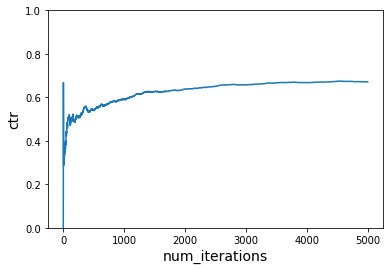

In [81]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, context1, context2, items, get_cost)

plot_ctr(num_iterations, ctr)

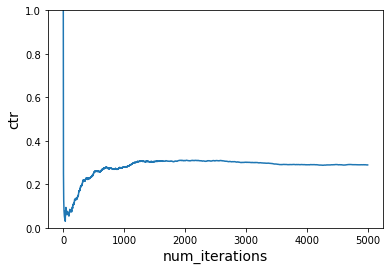

In [82]:
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, context1, context2, items, get_cost)

plot_ctr(num_iterations, ctr)

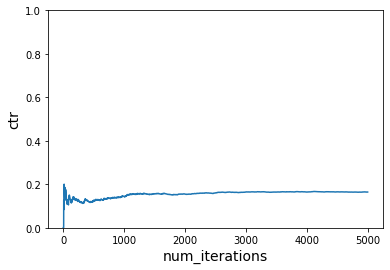

In [83]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, context1, context2, items, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

In [84]:
users = ['A','B','C']
items = ['Item1','Item2','Item3','Item4','Item5','Item6']
context1 = ['morning','evening']
context2 = ['summer','winter']

context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = 0

#user 1 likes Item 2 in morning, and Item 5 in summer
context.loc[(context.users=='A') & \
            (context.context1=='morning') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='A') & \
            (context.context2=='summer') & \
            (context['items']=='Item5'), \
            'reward'] = 1

#user 2 likes Item 2 in summer, and Item 5 in morning
context.loc[(context.users=='B') & \
            (context.context2=='summer') & \
            (context['items']=='Item2'), \
            'reward'] = 1
context.loc[(context.users=='B') & \
            (context.context1=='morning') & \
            (context['items']=='Item5'), \
            'reward'] = 1


#user 3 likes Item 4 in morning, Item 3 in evening, and item 4 in winter evening
context.loc[(context.users=='C') & \
            (context.context1=='morning') & \
            (context['items']=='Item4'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='evening') & \
            (context['items']=='Item3'), \
            'reward'] = 1
context.loc[(context.users=='C') & \
            (context.context1=='evening') & \
            (context.context2=='winter') & \
            (context['items']=='Item4'), \
            'reward'] = 1

context['cost'] = context['reward']*-1

contextdf_new = context.copy()

def get_cost_new1(context,action):
    return contextdf_new.loc[(contextdf_new['users']==context['user']) & \
            (contextdf_new.context1==context['context1']) & \
            (contextdf_new.context2==context['context2']) & \
            (contextdf_new['items']==action), \
            'cost'].values[0]

In [85]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, contexts1, contexts2, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
          user = choose_user(users)
          context1 = choose_context1(contexts1)
          context2 = choose_context2(contexts2)

          context = {'user': user, 'context1': context1, 'context2': context2}
          
          action, prob = get_action(vw, context, actions)
          cost = cost_function(context, action)
          cost_sum += cost

          if do_learn:
              vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
              vw.learn(vw_format)

          ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

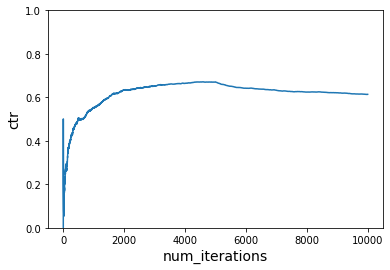

In [86]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, context1, context2, items, cost_functions)

plot_ctr(total_iterations, ctr)

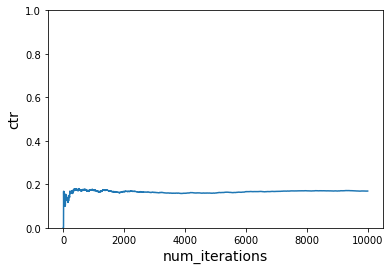

In [87]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, context1, context2, items, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)